# Trabajo Práctico 1
## PROCESAMIENTO DIGITAL DE SEÑALES

#### Alumno: Santiago Germino
#### MSE 4ta cohorte.

Un receptor de comunicaciones posee un frontend analógico que recibe señales moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial. El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la señal recibida se verá degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la señal.

Se dispone una trama digitalizada muestrada a 20 samples / pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100.

La modulación empleada es antipodal:
pulso positivo  -> bit 1
pulso negativo -> bit 0

Objetivos principales:
- Detectar la secuencia de bits recibida de forma confiable
- Investigar diferentes métodos de demodulación

Notas:

- La señal se encuentra sincronizada a nivel muestra. Por esta razón, la muestra 0 corresponde al comienzo de un pulso exponencial.
- Tener en cuenta que el objetivo es recuperar la información, lo cual no implica recuperar fielmente la señal enviada. Esto es clásico en problemas de comunicaciones: sabemos la forma de la modulación (la forma de los pulsos y como se modulan), lo que no sabemos es con qué valores fueron modulados.

Para ello se pide:

# PARTE 1a

Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes. ¿Es óptimo el filtro elegido para detectar la información en forma confiable?

<div class="alert alert-block alert-success"><b>Respuesta 1a</b>: Dado que se tomaron 20 samples de un mismo pulso, por un tema de conveniencia asumi que la frecuencia de sampling es de 20 Hz, luego hice un filtro pasa alto de 0 a 0.1 Hz. Eso genera que la continua sea siempre 0. Para filtrar las altas frecuencias (el contenido que es ruido de los samples 0 a 20 de la exponencial) hice un filtro pasabajo de 0 a 2 Hz con al intencion de mantener el fragmento del pulso exponencial y no el resto de samples que solo serian ruido.</div>

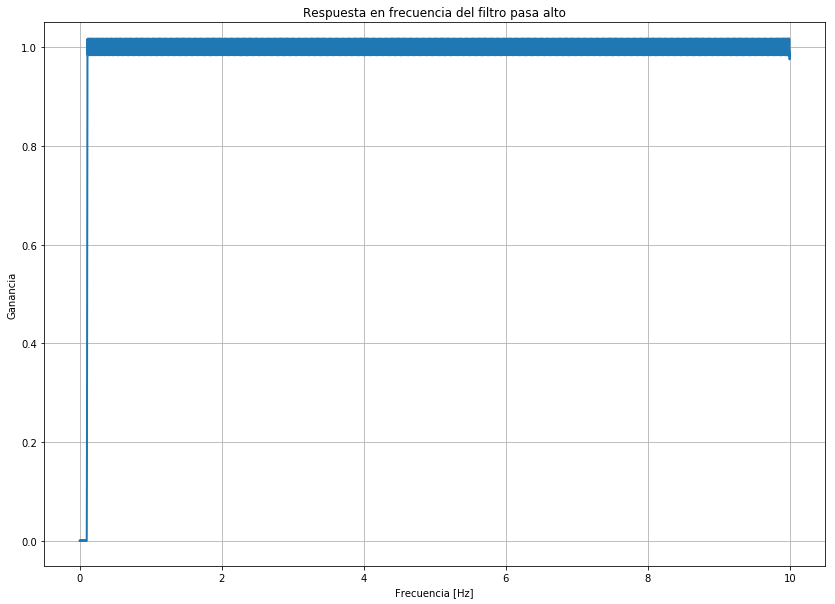

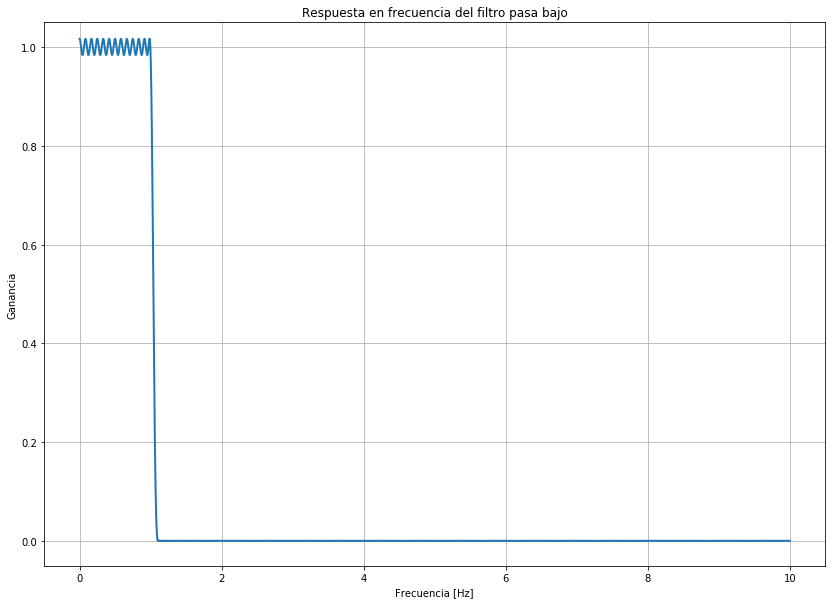

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack
import statistics as stats

# Funcion para graficar respuesta en frecuencia de filtros
def dibujarRespuestaFiltro2 (filter_coeff, filter_type):
    w, h = scipy.signal.freqz (filter_coeff, worN=8000)
    plt.figure (figsize=(14, 10))
    plt.plot   ((w / np.pi) * (Fs / 2), np.absolute(h), linewidth=2)
    plt.title  ('Respuesta en frecuencia del filtro ' + filter_type)
    plt.xlabel ('Frecuencia [Hz]')
    plt.ylabel ('Ganancia')
    plt.ylim   (-0.05, 1.05)
    plt.grid   (True)
    plt.show   ()

# Dado que hay 20 samples por pulso, por una cuestion de conveniencia se define 
# la frecuencia de sampling en 20 Hz.
Fs = 20

# Se cargan los dos filtros pasaalto y pasabajo. Ambos se diseñaron con la aplicación PyFDA.
pasaaltotaps = np.genfromtxt ('pasaalto.csv', delimiter = ",")
pasabajotaps = np.genfromtxt ('pasabajo.csv', delimiter = ",")

dibujarRespuestaFiltro2 (pasaaltotaps, 'pasa alto')
dibujarRespuestaFiltro2 (pasabajotaps, 'pasa bajo')

# Demora de grupo de los filtros FIR
delay = 0
delay += 0.5 * (len(pasaaltotaps) - 1) / Fs
delay += 0.5 * (len(pasabajotaps) - 1) / Fs

#### En el siguiente grafico se observa el resultado del filtrado aplicado a un tren de pulsos exponenciales (pulse.py repetido).
<img src="g6.png" />

# PARTE 1b
Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿es óptimo este umbral?

<div class="alert alert-block alert-success"><b>Respuesta 1b</b>: Para obtener el valor de 0 o 1 de cada pulso hice una media de los valores filtrados de los 20 samples por pulso. Si es < 0 es 0, si es >=, es 1. No, no es optimo este umbral. Quiza los filtros se puedan "sintonizar" mejor, pero tampoco es óptima esta técnica y dudo que genere el resultado esperado.</div>

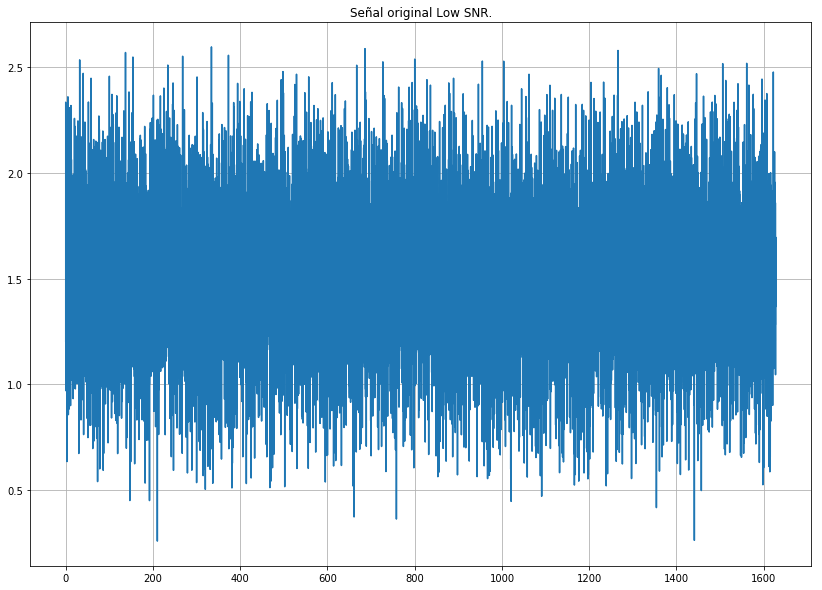

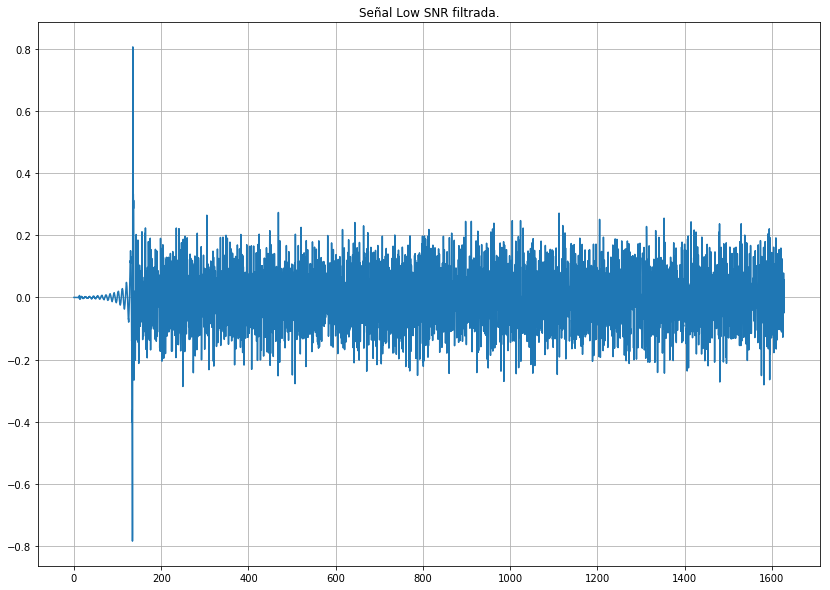

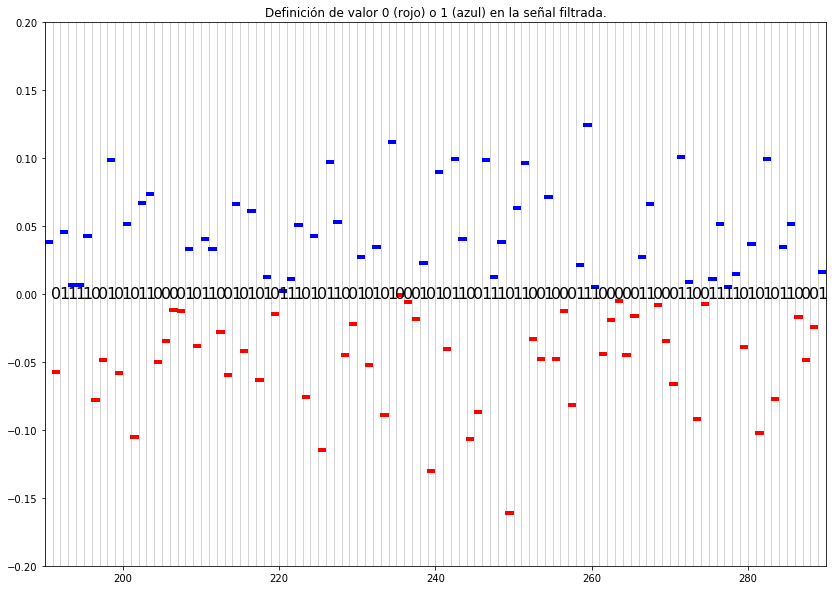

In [28]:
signalOriginal = np.load ('signal.npy')
signalLowSNR   = np.load ('signalLowSNR.npy')

N = len(signalLowSNR)

t = np.linspace (0.0, (N-1)/20, N).flatten ()

plt.figure (figsize=(14, 10))
plt.grid   (True)
plt.title  ('Señal original Low SNR.')
plt.plot   (t, signalLowSNR)
plt.show   ()

signalFilt = scipy.signal.lfilter (pasaaltotaps, 1.0, signalLowSNR)
signalFilt = scipy.signal.lfilter (pasabajotaps, 1.0, signalFilt)

plt.figure (figsize=(14, 10))
plt.grid   (True)
plt.title  ('Señal Low SNR filtrada.')
plt.plot   (t, signalFilt)
plt.show   ()

plt.figure (figsize=(14, 10))
plt.title  ('Definición de valor 0 (rojo) o 1 (azul) en la señal filtrada.')

# Por cada grupo de 20 samples se hace una media de esos 20 y se define si el valor es 0 o 1.
for i in range(0, N, 20):

    pulse_samples = signalFilt[i:i+20]
    pulse = pulse_samples.mean ()
    color = 'b'
    value = '1'
    if pulse < 0.0:
        color = 'r'
        value = '0'
    
    plt.plot ([i/20, i/20], [1, -1], 'lightgray', linewidth=1)
    plt.plot ([(i+4)/20, (i+16)/20], [pulse, pulse], color, linewidth=4)
    
    if i > 190*20 and i < 290*20:
        plt.text ((i/20 + (i+20)/20)/2, 0, value, fontsize=16, horizontalalignment='center', verticalalignment='center')

plt.axis ([190, 290, -0.2, 0.2])
plt.show ()

#### detalle de los valores 0 o 1 en la señal filtrada
<img src="g7c.png" />

<div class="alert alert-block alert-success">Tambien es importante aclarar que no obtuve casi ninguna secuencia 10101100 con la señal original (signal.npy). Por otro lado y como se observa en la imagen superior, si logre ver algunos bytes del header correctamente aplicando el mismo filtrado y metodo de obtener 0 o 1 a la señal de menor SNR (signalLowSNR.npy).</div>

# PARTE 2

Repetir el procedimiento para la parte 1, pero utilizar el filtro y el umbral óptimo.

<div class="alert alert-block alert-success"><b>Respuesta 2, filtro optimo</b>: Se implementa un filtro adaptado utilizando como los "taps" o respuesta impulsiva del filtro un pulso patrón invertido en el tiempo y aplicando convolucion.</div>

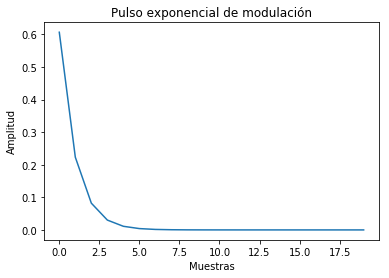

In [3]:
pulse = np.load ('pulse.npy')

plt.figure ()
plt.plot   (pulse)
plt.title  ('Pulso exponencial de modulación')
plt.xlabel ('Muestras')
plt.ylabel ('Amplitud')
plt.show   ()

In [4]:
# Pulso invertido, carga de señales y convolucion de las mismas
pulseFilt = pulse[::-1]

signalOriginal = np.load ('signal.npy')
signalLowSNR   = np.load ('signalLowSNR.npy')

signalOriginalFiltered = np.convolve (pulseFilt, signalOriginal)
signalLowSNRFiltered   = np.convolve (pulseFilt, signalLowSNR)

In [18]:
# Definición de una función que subsampleará y dibujara la señal. Tambien mostrara el resultado obtenido
# comparando los 16 bytes del header del mensaje. Se toma como fallo que un entero sea byte incorrecto
# aun si dentro del mismo solo un bit no fuese correcto.
def dibujarSubsamplearSenial (signal, samplemax, title):

    N = len(signal)

    # Se calcula la media de toda la señal para generar un offset de continua centrado en cero
    signalFilteredMean = stats.mean (signal)

    plt.figure (figsize=(16, 10))
    plt.title  (title)

    bitcount = 0
    curbyte = ''
    headerBytes = []

    for i in range(0, N, 20):

        # Ignoro el 1er valor (es un 0 perdido)
        if i == 0:
            continue

        # Se subsamplea tomando el 1er sample de los 20 que conforman un unico pulso
        pulse_samples = signal[i]
        pulse = pulse_samples - signalFilteredMean
        color = 'b'
        value = '1'
        if pulse < 0.0:
            color = 'r'
            value = '0'

        curbyte += value

        plt.plot ([i/20, i/20], [1, -1], 'lightgray', linewidth=1)

        if bitcount == 7:
            plt.plot ([(i+20)/20, (i+20)/20], [1, -1], linewidth=2)
            bitcount = 0
            if len(headerBytes) < 16:
                headerBytes.append (curbyte)
            curbyte = ''
        else:
            bitcount += 1

        plt.plot ([(i+4)/20, (i+16)/20], [pulse, pulse], color, linewidth=4)
        if i < samplemax*20:
             plt.text ((i/20 + (i+20)/20)/2, 0, value, fontsize=16, horizontalalignment='center', verticalalignment='center')

    plt.axis ([0, samplemax, -1, 1])
    plt.show ()
    
    return headerBytes


# Funcion para revisar que el contenido del header decodificado sea el esperado (byte 10101100 x 16) 
def chequearHeader (header):
    value   = '10101100'
    bytenum = 0
    bitsOk  = 0
    
    for v in header:
        result = "OK!"
        bcount = 8
        if v != value:
            for i in range(len(v)):
                if v[i] != value[i]:
                    bcount -= 1
            result = 'Error (' + str(8 - bcount) + ' bit)'
        
        bitsOk += bcount
        print ('byte ' + str(bytenum) + ' = "' + v + '" ' + result)
        bytenum += 1
    
    print ('-------------------------------------')
    print ('-------------------------------------')
    print (str(bitsOk*100/128) + '% de bits correctos.')

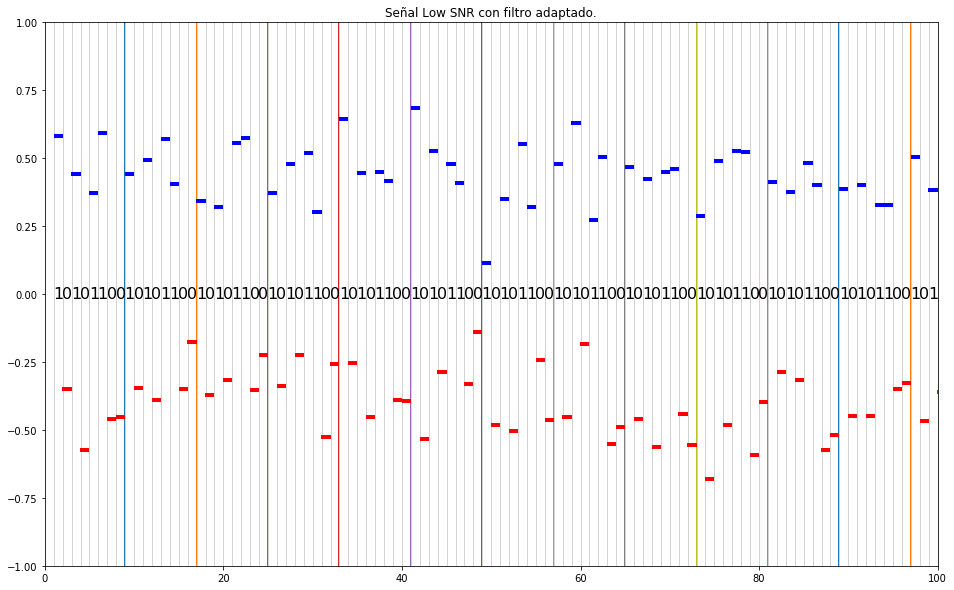

byte 0 = "10101100" OK!
byte 1 = "10101100" OK!
byte 2 = "10101100" OK!
byte 3 = "10101100" OK!
byte 4 = "10101100" OK!
byte 5 = "10101100" OK!
byte 6 = "10101100" OK!
byte 7 = "10101100" OK!
byte 8 = "10101100" OK!
byte 9 = "10101100" OK!
byte 10 = "10101100" OK!
byte 11 = "10101100" OK!
byte 12 = "10101100" OK!
byte 13 = "10101100" OK!
byte 14 = "10101100" OK!
byte 15 = "10101100" OK!
-------------------------------------
-------------------------------------
100.0% de bits correctos.


In [19]:
header = dibujarSubsamplearSenial (signalLowSNRFiltered, 100, 'Señal Low SNR con filtro adaptado.')
chequearHeader (header)

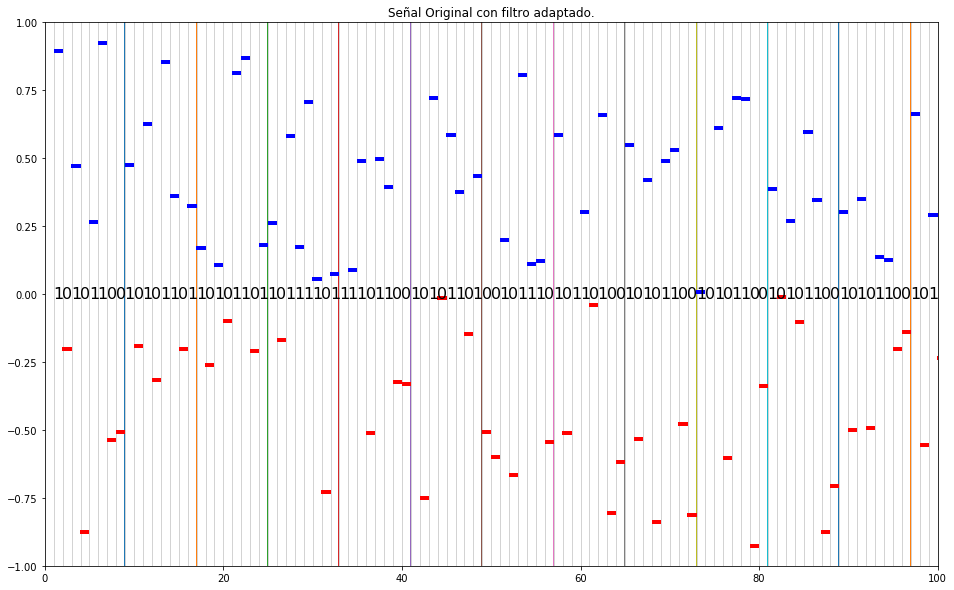

byte 0 = "10101100" OK!
byte 1 = "10101101" Error (1 bit)
byte 2 = "10101101" Error (1 bit)
byte 3 = "10111101" Error (2 bit)
byte 4 = "11101100" Error (1 bit)
byte 5 = "10101101" Error (1 bit)
byte 6 = "00101110" Error (2 bit)
byte 7 = "10110100" Error (2 bit)
byte 8 = "10101100" OK!
byte 9 = "10101100" OK!
byte 10 = "10101100" OK!
byte 11 = "10101100" OK!
byte 12 = "10101110" Error (1 bit)
byte 13 = "10101100" OK!
byte 14 = "00101100" Error (1 bit)
byte 15 = "10101101" Error (1 bit)
-------------------------------------
-------------------------------------
89.84375% de bits correctos.


In [20]:
header = dibujarSubsamplearSenial (signalOriginalFiltered, 100, 'Señal Original con filtro adaptado.')
chequearHeader (header)

<div class="alert alert-block alert-success"><b>Respuesta 2, umbral optimo</b>: Se conoce que la probabilidad de obtener un valor 0 o 1 es equiprobable, por este motivo se toma la media de toda la señal como el umbral. En otros casos no equiprobables (o para estar completamente seguro de que se eligió el umbral optimo) seria necesario realizar dos histogramas con los valores que uno espera obtener y sus resultados. El umbral optimo estaria ubicado entre el desvio estandar de la probabilidad de ambos valores. Si el desvio estandar de ambas se solapa (como sucede con la señal original con gran nivel de ruido) entonces en esa interseccion no seria posible determinar si el valor de la señal es 0 o 1.</div>